In [1]:
import pyarrow.parquet as pq
import pandas as pd
import os
import googlemaps
import openrouteservice
import numpy as np
from tqdm import tqdm
import time
from geopy.distance import geodesic
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
GOOGLE_MAPS_API_KEY = os.environ['GOOGLE_MAPS_API_KEY']
gmaps = googlemaps.Client(key=GOOGLE_MAPS_API_KEY)

KeyError: 'GOOGLE_MAPS_API_KEY'

# Get intervention coordinates

In [2]:
def format_coordinates(longitude, latitude):
    formatted_longitude = str(longitude)[:1] + '.' + str(longitude).replace('.', '')[1:]
    formatted_latitude = str(latitude)[:2] + '.' + str(latitude).replace('.', '')[2:]
    return formatted_longitude, formatted_latitude


def process_and_display_map_data(df, selected_file, show_cardiac_incidences):
    map_data = pd.DataFrame(columns=['lat', 'lon'])
    config = file_configs[selected_file]

    for index, row in df.iterrows():
        current_longitude = row[config['columns']['longitude']]
        current_latitude = row[config['columns']['latitude']]
        if pd.isnull(current_longitude) or pd.isnull(current_latitude):
            continue

        current_longitude, current_latitude = format_coordinates(current_longitude, current_latitude)

        if show_cardiac_incidences == 'Yes':
            is_interesting = any(event_type in row[config['columns']['event']] for event_type in config['event_types']) if row[config['columns']['event']] else False
            if is_interesting:
                map_data = pd.concat([map_data, pd.DataFrame({'lat': [float(current_latitude)], 'lon': [float(current_longitude)]})], ignore_index=True)
        else:
            map_data = pd.concat([map_data, pd.DataFrame({'lat': [float(current_latitude)], 'lon': [float(current_longitude)]})], ignore_index=True)
    
    return map_data

In [3]:
intervention1 = pq.ParquetFile(os.path.join('../data', 'interventions1.parquet.gzip')).read().to_pandas()
intervention2 = pq.ParquetFile(os.path.join('../data', 'interventions2.parquet.gzip')).read().to_pandas()
intervention3 = pq.ParquetFile(os.path.join('../data', 'interventions3.parquet.gzip')).read().to_pandas()
intervention4 = pq.ParquetFile(os.path.join('../data', 'interventions_bxl.parquet.gzip')).read().to_pandas()
intervention5 = pq.ParquetFile(os.path.join('../data', 'interventions_bxl2.parquet.gzip')).read().to_pandas()

In [23]:
intervention1.iloc[0]

mission_id                                          10221520001
service_name                           HA UR MECH AZ St Maarten
postalcode_permanence                                    2800.0
cityname_permanence                         Mechelen (Mechelen)
streetname_permanence                            Liersesteenweg
housenumber_permanence                                     None
latitude_permanence                                    51.05102
longitude_permanence                                    4.47803
permanence_short_name                                 AAMECH01A
permanence_long_name                              ZW MECHELEN 1
vector_type                                           Ambulance
eventtype_firstcall                 P020 - Intoxication alcohol
eventlevel_firstcall                                         N5
eventtype_trip                      P020 - Intoxication alcohol
eventlevel_trip                                               5
postalcode_intervention                 

In [38]:
intervention1['t3']

0         2022-06-01 00:17:53.888
1         2022-06-01 00:16:25.356
2         2022-06-01 00:35:58.397
3         2022-06-01 00:27:35.760
4         2022-06-01 00:25:28.053
                   ...           
200622    2022-07-11 07:13:41.402
200623    2022-07-11 07:09:30.712
200624    2022-07-11 07:21:20.130
200625    2022-07-11 07:23:44.727
200626    2022-07-11 07:33:37.331
Name: t3, Length: 200627, dtype: object

In [39]:
pd.to_datetime(intervention1['t3'], format='%Y-%m-%d %H:%M:%S.%f')

0        2022-06-01 00:17:53.888
1        2022-06-01 00:16:25.356
2        2022-06-01 00:35:58.397
3        2022-06-01 00:27:35.760
4        2022-06-01 00:25:28.053
                   ...          
200622   2022-07-11 07:13:41.402
200623   2022-07-11 07:09:30.712
200624   2022-07-11 07:21:20.130
200625   2022-07-11 07:23:44.727
200626   2022-07-11 07:33:37.331
Name: t3, Length: 200627, dtype: datetime64[ns]

In [4]:
for intervention_df in [intervention1, intervention2, intervention3, intervention4, intervention5]:
    intervention_df.columns = intervention_df.columns.str.lower().str.replace(' ', '_')

In [5]:
intervention4 = intervention4.rename(columns={'calculated_distance_destination_': 'calculated_distance_destination', 
                              'departure_time_t1reported': 'departure_time_(t1reported)',
                              'intervention_time_t1reported': 'intervention_time_(t1reported)'})

In [6]:
intervention5 = intervention5.rename(columns={'eventtype_and_eventlevel': 'eventtype_trip', 
                              'vector_type_nl': 'vector_type',
                              'abandon_reason_nl': 'abandon_reason'})

In [7]:
for intervention in [intervention1, intervention2, intervention3, intervention4]:
    intervention['eventlevel_trip'] = intervention['eventlevel_trip'].str.extract(r'N(\d{1})', expand=False)
    t3s = pd.to_datetime(intervention['t3'].str.replace('+00:00', '').str.strip(), format='%Y-%m-%d %H:%M:%S.%f')
    t6s = pd.to_datetime(intervention['t6'].str.replace('+00:00', '').str.strip(), format='%Y-%m-%d %H:%M:%S.%f')
    intervention['travel_time'] = (t6s - t3s).dt.total_seconds() / 60
intervention5['eventlevel_trip'] = intervention5['eventtype_trip'].str.extract(r'N0(\d{1})', expand=False)
intervention5['waiting_time'] = (pd.to_datetime(intervention5['t3'], format='%d%b%y:%H:%M:%S') - pd.to_datetime(intervention5['t0'], format='%d%b%y:%H:%M:%S')).dt.total_seconds() / 60
intervention5['travel_time'] = (pd.to_datetime(intervention5['t6'], format='%d%b%y:%H:%M:%S') - pd.to_datetime(intervention5['t3'], format='%d%b%y:%H:%M:%S')).dt.total_seconds() / 60

In [11]:
common_columns = list(set(intervention1.columns) & set(intervention4.columns))
common_columns

['waiting_time',
 'housenumber_permanence',
 't2',
 'longitude_intervention',
 't4',
 'postalcode_intervention',
 't7',
 'calculated_distance_destination',
 'travel_time',
 'permanence_short_name',
 'postalcode_permanence',
 'latitude_permanence',
 'number_of_transported_persons',
 'cityname_intervention',
 'cityname_destination_hospital',
 'eventtype_firstcall',
 't5',
 'intervention_duration',
 'housenumber_destination_hospital',
 't6',
 't0',
 'service_name',
 'name_destination_hospital',
 'streetname_destination_hospital',
 'longitude_permanence',
 'vector_type',
 'postalcode_destination_hospital',
 'latitude_intervention',
 'eventlevel_firstcall',
 'mission_id',
 'departure_time_(t1reported)',
 't1',
 'unavailable_time',
 'eventtype_trip',
 'eventlevel_trip',
 't3',
 't1confirmed',
 'abandon_reason',
 'cityname_permanence',
 't9',
 'calculated_traveltime_destinatio',
 'intervention_time_(t1reported)',
 'streetname_permanence',
 'permanence_long_name']

In [12]:
interventions = pd.concat([intervention1[common_columns], intervention2[common_columns], intervention3[common_columns], intervention4[common_columns]], ignore_index=True)
interventions = interventions.loc[~(interventions['waiting_time'] < 0)]
arrests = interventions.loc[interventions['eventtype_trip'].str.contains("Cardiac arrest|Chest pain|HARTSTILSTAND|PIJN OP DE BORST|CARDIAAL PROBLEEM", na=False)]

In [13]:
arrests['survived'] = ~arrests['abandon_reason'].isin(['Overleden', 'Dood Ter Plaatse'])
arrests.shape

/var/folders/8t/4mtztt010752cj_569fwq_h00000gp/T/ipykernel_59706/2543895568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrests['survived'] = ~arrests['abandon_reason'].isin(['Overleden', 'Dood Ter Plaatse'])


(42486, 45)

In [75]:
numeric_columns

Index(['waiting_time', 'longitude_intervention',
       'calculated_distance_destination', 'travel_time',
       'postalcode_permanence', 'latitude_permanence',
       'number_of_transported_persons', 'intervention_duration',
       'longitude_permanence', 'latitude_intervention', 'mission_id',
       'departure_time_(t1reported)', 'unavailable_time',
       'calculated_traveltime_destinatio', 'intervention_time_(t1reported)',
       'survived'],
      dtype='object')

In [ ]:
arrests['number_of_transported_persons'] 

In [67]:
numeric_columns = arrests._get_numeric_data().columns

In [87]:
for column in arrests.columns:
    if column not in ['waiting_time', 'survived', 'abandon_reason', 't0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 
                      'number_of_transported_persons','cityname_destination_hospital', 'housenumber_destination_hospital', 
                      'name_destination_hospital', 'postalcode_destination_hospital']:
        print(column)
        max_waiting_time = 9999999
        arrests_filtered = arrests.loc[arrests['waiting_time'] < max_waiting_time, ['waiting_time', column, 'survived']].dropna()

        X = arrests_filtered[[
            'waiting_time', 
            column
        ]
        ]
        
        if column not in numeric_columns:
            X = pd.get_dummies(X, columns=[column], drop_first=True)
        # X['eventlevel_trip'] = X['eventlevel_trip'].astype(float)

        y = arrests_filtered['survived']

        # Split the data into training and testing sets
        imputer = SimpleImputer()

        # Preprocess the data by imputing missing values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        # Define the class weights
        class_weights = {0: 15, 1: 1}

        # Create the classifier with class weights
        model = LogisticRegression(class_weight=class_weights)

        # Fit the classifier to your data
        model.fit(X_train, y_train)

        # Predict the target variable for the test set
        y_pred = model.predict(X_test)

        # Print coefficient of waiting_time
        print(model.coef_[0][0])

housenumber_permanence
0.006656829848406184
longitude_intervention


/opt/homebrew/Caskroom/miniforge/base/envs/mda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.009027852056715182
postalcode_intervention
0.029550016308961605
calculated_distance_destination


/opt/homebrew/Caskroom/miniforge/base/envs/mda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.04764953206159759
travel_time
0.049763197857369386
permanence_short_name


/opt/homebrew/Caskroom/miniforge/base/envs/mda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.011831398542743364
postalcode_permanence
0.008553762075615253
latitude_permanence
1.2262809080957975e-18
cityname_intervention


/opt/homebrew/Caskroom/miniforge/base/envs/mda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.009761411375967892
eventtype_firstcall


/opt/homebrew/Caskroom/miniforge/base/envs/mda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.0007566262036700334
intervention_duration
0.010962268964998703
service_name


/opt/homebrew/Caskroom/miniforge/base/envs/mda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.0018327523914704754
streetname_destination_hospital
0.059196251676482625
longitude_permanence
1.305389678016889e-18
vector_type
0.010723518703570462
postalcode_destination_hospital


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: True

In [ ]:
max_waiting_time = 9999999
arrests_filtered = arrests.loc[arrests['waiting_time'] < max_waiting_time, ['waiting_time', 'number_of_transported_persons', 'survived']].dropna()

X = arrests_filtered[[
    'waiting_time', 
    'number_of_transported_persons'
]
]

# X = pd.get_dummies(X, columns=['eventlevel_trip'], drop_first=True)
# X['eventlevel_trip'] = X['eventlevel_trip'].astype(float)

y = arrests_filtered['survived']

# Split the data into training and testing sets
imputer = SimpleImputer()

# Preprocess the data by imputing missing values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Define the class weights
class_weights = {0: 15, 1: 1}

# Create the classifier with class weights
model = LogisticRegression(class_weight=class_weights)

# Fit the classifier to your data
model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = model.predict(X_test)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, labels=model.classes_), display_labels=model.classes_)
disp.plot()

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: True

In [20]:
arrests.iloc[10].sort_index()

abandon_reason                                         None
calculated_distance_destination                       795.0
calculated_traveltime_destinatio                       86.0
cityname_destination_hospital                   Geel (Geel)
cityname_intervention                           Geel (Geel)
cityname_permanence                             Geel (Geel)
departure_time_(t1reported)                            64.0
eventlevel_firstcall                                     N2
eventlevel_trip                                           2
eventtype_firstcall                       P011 - Chest pain
eventtype_trip                            P011 - Chest pain
housenumber_destination_hospital                       None
housenumber_permanence                                 None
intervention_duration                                  60.0
intervention_time_(t1reported)                          5.0
latitude_intervention                              51.16195
latitude_permanence                     

In [16]:
model.coef_

array([[ 0.03454806,  0.02992366,  1.09530997,  2.86574908,  6.00078828,
         5.00333659,  1.38959097, -0.19213796,  0.0392028 ]])

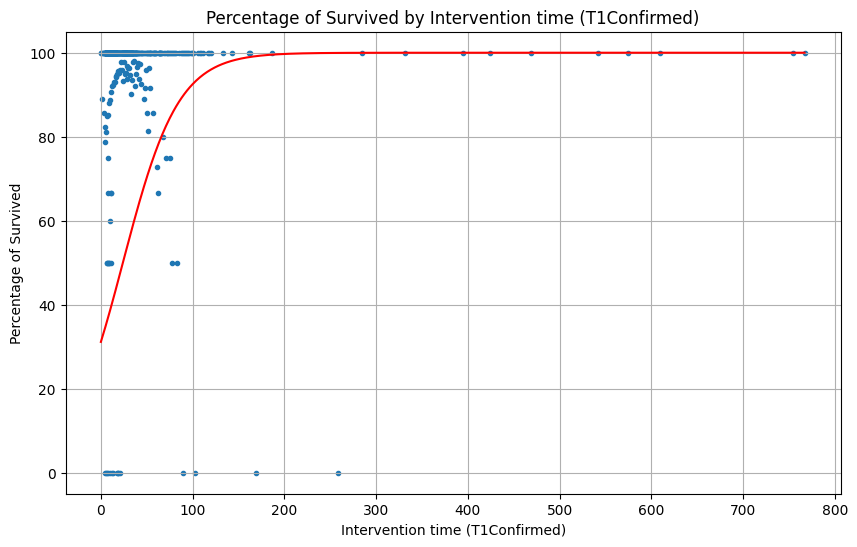

In [454]:
# Group the data by Intervention time (T1Confirmed) and calculate the percentage of Survived
survived_percentage = arrests_filtered.groupby('waiting_time')['survived'].mean() * 100
intervention_times = np.arange(0, arrests_filtered['waiting_time'].max(), 1)
predicted_percentages = model.predict_proba(intervention_times[:, np.newaxis])[:, 1] * 100


# Plot the percentage of Survived by Intervention time (T1Confirmed)
plt.figure(figsize=(10, 6))
plt.scatter(survived_percentage.index, survived_percentage.values, marker='.')
plt.plot(intervention_times, predicted_percentages, color='red', label='Logistic Regression')
plt.xlabel('Intervention time (T1Confirmed)')
plt.ylabel('Percentage of Survived')
plt.title('Percentage of Survived by Intervention time (T1Confirmed)')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt


In [43]:
# Remove non-numeric columns from the dataframe
numeric_columns = arrests_with_short_intervention_time.select_dtypes(include=[np.number]).columns
df_numeric = arrests_with_short_intervention_time[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()
correlation_matrix

,Mission ID,PostalCode permanence,Latitude permanence,Longitude permanence,Latitude intervention,Longitude intervention,Intervention time (T1Reported),Intervention time (T1Confirmed),Waiting time,Intervention duration,Departure time (T1Reported),Departure time (T1Confirmed),Unavailable time,Calculated travelTime destinatio,Calculated Distance destination,Number of transported persons,Survived
Mission ID,1.000000,0.575174,0.018155,0.034865,0.017755,0.043463,0.061022,0.012527,0.057310,0.128469,-0.032409,0.019086,NaN,0.128625,0.112071,-0.013288,-0.055989
PostalCode permanence,0.575174,1.000000,0.084264,0.040294,0.016144,0.037482,0.097409,0.056789,0.078251,0.092349,0.017354,0.015725,NaN,0.097977,0.012048,-0.035267,-0.077289
Latitude permanence,0.018155,0.084264,1.000000,0.913057,0.774034,0.901578,0.031605,0.033936,0.014854,0.008694,0.014689,-0.000776,NaN,0.052661,-0.036052,-0.004998,-0.010552
Longitude permanence,0.034865,0.040294,0.913057,1.000000,0.916343,0.903703,0.025190,0.035171,0.015272,0.001493,0.035372,-0.004589,NaN,0.105791,-0.204979,0.004065,0.037126
Latitude intervention,0.017755,0.016144,0.774034,0.916343,1.000000,0.852948,-0.007087,0.001509,0.000859,0.015560,0.034346,0.000719,NaN,0.037959,-0.063628,-0.010255,0.012702
Longitude intervention,0.043463,0.037482,0.901578,0.903703,0.852948,1.000000,0.010305,0.015097,0.004033,0.003390,0.029857,-0.005437,NaN,0.101601,-0.204462,0.000931,0.011599
Intervention time (T1Reported),0.061022,0.097409,0.031605,0.025190,-0.007087,0.010305,1.000000,0.833845,0.703446,0.153066,0.214915,-0.025836,NaN,0.095838,0.122644,0.022401,0.149464
Intervention time (T1Confirmed),0.012527,0.056789,0.033936,0.035171,0.001509,0.015097,0.833845,1.000000,0.598132,0.106235,0.187432,0.010956,NaN,0.168084,0.178963,0.048802,0.155678
Waiting time,0.057310,0.078251,0.014854,0.015272,0.000859,0.004033,0.703446,0.598132,1.000000,0.222956,0.139204,0.007474,NaN,0.113988,0.154731,0.155381,0.130589
Intervention duration,0.128469,0.092349,0.008694,0.001493,0.015560,0.003390,0.153066,0.106235,0.222956,1.000000,-0.003213,0.005945,NaN,0.385136,0.384980,-0.034014,0.220402


In [5]:
coordinates1 = process_and_display_map_data(intervention1, 'interventions1.parquet.gzip', show_cardiac_incidences='Yes')
coordinates2 = process_and_display_map_data(intervention2, 'interventions1.parquet.gzip', show_cardiac_incidences='Yes')
coordinates3 = process_and_display_map_data(intervention3, 'interventions1.parquet.gzip', show_cardiac_incidences='Yes')

/var/folders/8t/4mtztt010752cj_569fwq_h00000gp/T/ipykernel_38548/3342450.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  map_data = pd.concat([map_data, pd.DataFrame({'lat': [float(current_latitude)], 'lon': [float(current_longitude)]})], ignore_index=True)
/var/folders/8t/4mtztt010752cj_569fwq_h00000gp/T/ipykernel_38548/3342450.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  map_data = pd.concat([map_data, pd.DataFrame({'lat': [float(current_latitude)], 'lon': [float(current_longitude

In [331]:
intervention_coordinates = pd.concat([coordinates1, coordinates2, coordinates3], ignore_index=True)
intervention_coordinates = intervention_coordinates.drop_duplicates()
intervention_coordinates['id'] = range(len(intervention_coordinates))
intervention_coordinates.to_csv('../transformed_data/intervention_coordinates.csv', index=False)

In [219]:
intervention_coordinates.shape

(32975, 3)

# Get AED coordinates

In [62]:
aed_locations = pq.ParquetFile(os.path.join('../data', 'aed_locations.parquet.gzip')).read().to_pandas()

In [ ]:
aed_addresses = []
for index, location in aed_locations.iterrows():
    number = '' if pd.isnull(location['number']) else location['number']
    postal_code = '' if pd.isnull(location['postal_code']) else int(location['postal_code'])
    address = f"{number} {location['address']}, {location['municipality']}, {location['province']}, Belgium {postal_code}"
    aed_addresses.append(address)

aed_locations['full_address'] = aed_addresses

In [97]:
aed_locations = aed_locations.drop_duplicates(subset=['full_address'])
aed_locations['id'] = range(len(aed_locations))
aed_locations

,id,type,address,number,postal_code,municipality,province,location,public,available,hours,full_address
0,0,None,Blvd. Fr. Roosevelt,24.0,7060.0,SOIGNIES,Hainaut,None,Y,None,None,"24.0 Blvd. Fr. Roosevelt, SOIGNIES, Hainaut, B..."
1,1,None,Ch. De Wégimont,76.0,4630.0,Ayeneux,Liège,None,None,None,None,"76.0 Ch. De Wégimont, Ayeneux, Liège, Belgium ..."
2,2,None,Place Saint - Lambert,NaN,4020.0,Liège,Liège,None,None,None,None,"Place Saint - Lambert, Liège, Liège, Belgium ..."
3,3,None,Rue du Doyard,NaN,4990.0,Lierneux,Liège,None,None,None,None,"Rue du Doyard, Lierneux, Liège, Belgium 4990"
4,4,None,Fond Saint Servais,NaN,4000.0,Liège,Liège,None,None,None,None,"Fond Saint Servais, Liège, Liège, Belgium 4000"
...,...,...,...,...,...,...,...,...,...,...,...,...
15221,13799,Appareil fixe-Vast apparaat,Nekkerspoel-Borcht,19.0,2800.0,Mechelen,Antwerpen,"Hoofdgebouw, 1ste verdieping, thv cafetaria",Oui-Ja,Non-Nee,maandag tot en met vrijdag van 8 tot 23 uur; w...,"19.0 Nekkerspoel-Borcht , Mechelen, Antwerpen,..."
15223,13800,Appareil fixe-Vast apparaat,Nieuwe Dreef,17.0,9160.0,Lokeren,Oost-Vlaanderen,Locatie : ingang poort hoofdgebouw,Oui-Ja,Oui-Ja,None,"17.0 Nieuwe Dreef , Lokeren, Oost-Vlaanderen, ..."
15224,13801,Appareil fixe-Vast apparaat,Panterschipstraat,207.0,9000.0,Gent,Oost-Vlaanderen,,Oui-Ja,Non-Nee,None,"207.0 Panterschipstraat , Gent, Oost-Vlaandere..."
15225,13802,Appareil fixe-Vast apparaat,Albert Leemansplein,20.0,1050.0,Bruxelles,Bruxelles-Brussel,,Oui-Ja,Non-Nee,None,"20.0 Albert Leemansplein, Bruxelles, Bruxelles..."


In [101]:
def get_lat_lon(address):
    # Geocode an address
    result = gmaps.geocode(address)

    # If result is not empty, extract latitude and longitude
    if result:
        location = result[0]['geometry']['location']
        return location['lat'], location['lng']
    else:
        return None, None

In [105]:
aed_lats = []
aed_lons = []

for address in aed_locations['full_address']:
    lat, lon = get_lat_lon(address)
    aed_lats.append(lat)
    aed_lons.append(lon)

In [108]:
aed_locations['lat'] = aed_lats
aed_locations['lon'] = aed_lons

In [332]:
aed_locations.to_csv('../transformed_data/aed_locations_full.csv', index=False)

# Get distance between intervention & AED coordinates

In [3]:
intervention_coordinates = pd.read_csv('../transformed_data/intervention_coordinates.csv')
aed_locations = pd.read_csv('../transformed_data/aed_locations_full.csv')

In [15]:
intervention_latlons = intervention_coordinates[['lat', 'lon']].values.tolist()
aed_latlons = aed_locations[['lat', 'lon']].values.tolist()

In [16]:
intervention_lonlats = intervention_coordinates[['lon', 'lat']].values.tolist()
aed_lonlats = aed_locations[['lon', 'lat']].values.tolist()

## Straight line distances

In [17]:
intervention_latlons_radians = np.radians(np.array(intervention_latlons))
aed_latlons_radians = np.radians(np.array(aed_latlons))

In [18]:
%time intervention_to_aed_distances_km = haversine_distances(intervention_latlons_radians, aed_latlons_radians) * 6371000/1000

CPU times: user 12.7 s, sys: 2.18 s, total: 14.8 s
Wall time: 15.6 s


In [13]:
np.save("../transformed_data/intervention_to_aed_distances_km.npy", intervention_to_aed_distances_km)

## Route distances

In [17]:
OPEN_ROUTE_SERVICE_API_KEY = os.environ['OPEN_ROUTE_SERVICE_API_KEY']
client = openrouteservice.Client(key=OPEN_ROUTE_SERVICE_API_KEY)  # Initialize client with your API key

In [23]:
%env OPEN_ROUTE_SERVICE_API_KEY=5b3ce3597851110001cf624805c793bf13394bf184fdf8716b14ab69

env: OPEN_ROUTE_SERVICE_API_KEY=5b3ce3597851110001cf624805c793bf13394bf184fdf8716b14ab69


In [24]:
client = openrouteservice.Client(key=OPEN_ROUTE_SERVICE_API_KEY)

In [25]:
def get_route_distances(source_coords, destination_coords):
    all_coords = source_coords + destination_coords
    routes = client.distance_matrix(source_coords + destination_coords, sources=list(range(len(source_coords))), destinations=list(range(len(source_coords), len(all_coords))), metrics=['distance'], units='km', validate=False)
    return np.array(routes['distances'])

In [7]:
# Split intervention_lonlats and aed_lonlats into chunks of 50 locations
intervention_chunks = [intervention_lonlats[i:i + 50] for i in range(0, len(intervention_lonlats), 50)]
aed_chunks = [aed_lonlats[i:i + 50] for i in range(0, len(aed_lonlats), 50)]

In [27]:
# Initialize an empty matrix to hold the distances
route_distances = np.full((len(intervention_lonlats), len(aed_lonlats)), np.nan)
elapsed_times = []

# Compute the distance matrix for each chunk
for i, intervention_chunk in enumerate(intervention_chunks):
    for j, aed_chunk in enumerate(aed_chunks):
        start_time = time.time()
        matrix = get_route_distances(intervention_chunk, aed_chunk)
        route_distances[i*50:(i+1)*50, j*50:(j+1)*50] = matrix
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Chunk {i+1} of {len(intervention_chunks)} and {j+1} of {len(aed_chunks)} completed in {elapsed_time} seconds")
        elapsed_times.append(elapsed_time)

ApiError: 403 ({'error': 'Access to this API has been disallowed'})

In [415]:
np.mean(elapsed_times) * (len(intervention_coordinates)/50 * len(aed_locations)/50) / 3600

46.49955369657295